# Training Environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

## Prepare Data

In [2]:
import torchvision.datasets as datasets

mnist = False
cifar10 = True
cifar100 = False
assert mnist ^ cifar10 ^ cifar100

n_classes = 10
if mnist:
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
if cifar10:
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
if cifar100:
    n_classes = 100
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=None)

print(trainset)
print(testset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


In [3]:
def to_rgb(x_grey: torch.Tensor) -> torch.Tensor:
    if len(x_grey.size()) == 3:
        helper = torch.unsqueeze(x_grey, 1)
        return helper.repeat(1, 3, 1, 1).float()
    elif len(x_grey.size()) == 4 and x_grey.size()[1] == 1:
        return x_grey.repeat(1, 3, 1, 1).float()
    elif len(x_grey.size()) == 4 and x_grey.size()[1] == 3:
        return x_grey
    elif len(x_grey.size()) == 4:
        raise ValueError(f'The size of this image tensor is not valid.\
        A 4th order image tensor must have dim1==1 (grey-scale) or dim1==3 (rgb).\
        Unknown format cannot be transformed to rgb.')
    else:
        raise ValueError(f'The size of this image-tensor is not valid.\
        Must be either 3rd (grey-scale) order tensor or 4th order tensor (rgb).\
        Got order {len(x_grey.size())}')
        
def swap_data(X):
    X1 = np.swapaxes(X, 1, 3)
    X2 = np.swapaxes(X1, 2, 3)
    return X2

if mnist:
    X_train_grey = trainset.train_data
    X_train = to_rgb(X_train_grey)
    X_test_grey = testset.test_data
    X_test = to_rgb(X_test_grey)
    y_train = trainset.train_labels
    y_test = testset.test_labels
else:
    X_train = torch.tensor(swap_data(trainset.data))
    y_train = torch.tensor(trainset.targets)
    X_test = torch.tensor(swap_data(testset.data))
    y_test = torch.tensor(testset.targets)
    
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: torch.Size([50000, 3, 32, 32])
y_train: torch.Size([50000])
X_test: torch.Size([10000, 3, 32, 32])
y_test: torch.Size([10000])


## Model load, modifications and GPU optimization

In [4]:
from torchvision import models

model = models.resnet18(pretrained=False) # set model here
in_ftr = model.fc.in_features
out_ftr = n_classes
model.fc = nn.Linear(in_ftr,out_ftr,bias=True)

# redefining stuff for AdaSecant test runs
#X_train = torch.rand(256, 10)
#X_test = torch.rand(256, 10)
#y_train = torch.randint(10, (256,))
#y_test = torch.randint(10, (256,))
#X_train = torch.tensor([[0], [1], [2], [3], [4], [5]])
#y_train = torch.tensor([[10], [8], [6], [4], [2], [0]])
#X_test = torch.tensor([[1], [3], [5]])
#y_test = torch.tensor([[8], [4], [0]])

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

#model = torch.nn.Sequential(nn.Linear(10, 10), nn.Linear(10, 10))
#model = nn.Linear(1, 1)

dataset_train = BasicDataset(X_train, y_train)
dataset_test = BasicDataset(X_test, y_test)

X_train: torch.Size([50000, 3, 32, 32])
y_train: torch.Size([50000])
X_test: torch.Size([10000, 3, 32, 32])
y_test: torch.Size([10000])


Check specs for GPU-based training.

In [5]:
print('cuda available:', torch.cuda.is_available())
print('cuda device name:', torch.cuda.get_device_name())
print('cuda device id', torch.cuda.current_device())

cuda available: True
cuda device name: NVIDIA GeForce 940MX
cuda device id 0


Move model and data to GPU.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train.to(device)
print('worked?', X_train.to(device).is_cuda)

worked? True


## Implementing AdaSecant
https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py

<ins>Indices:

- $i\in\{1, ..., n\}$: parameter

- $k\in\{1, ..., m\}$: sample in minibatch

- $j\in\{1, ..., n_{iter}\}$: iteration, $n_{iter} = \lfloor\frac{epochs}{m}\rfloor$ if drop_last else $n_{iter} = \lceil\frac{epochs}{m}\rceil$



<ins>Gradients $g, g'$:

$g^{(j)} = \frac{1}{m}\sum_{k=1}^m\nabla_{\theta_i}f(\theta^{(k)})$ is the current gradient. $g'^{(j)} = \frac{1}{m}\sum_{k=m+1}^{2m}\nabla_{\theta_i}f(\theta^{(k)})$ is the gradient calculated on the consecutive minibatch with the current parameters.
    
Second test run: apply normalization $\hat{g} = \frac{g}{||E[g]||_2}$.


<ins>Moving averages $E[x]_j$:

$$
\begin{aligned}
    E[x]_j &= \left(1 - \frac{1}{\tau^{(j)}}\right)E[x]_{j-1} + \frac{1}{\tau^{(j)}}x^{(j)}
\end{aligned}
$$


<ins>Elements of the Hessian diagnonal $\alpha_i$:

$$
\begin{aligned}
    \alpha_i &= \nabla_{\theta_i}f(\theta + \Delta) - \nabla_{\theta_i}f(\theta)
\end{aligned}
$$

"The Equation 13 can be easily computed in a stochastic setting from the consecutive minibatches":

$$
\begin{aligned}
    \alpha_i^{(j)} &= \nabla_{\theta_i}f(\theta^{(j-1)} + \Delta^{(j-1)}) - \nabla_{\theta_i}f(\theta^{(j-1)}) \\
    &= \nabla_{\theta_i}f(\theta^{(j)}) - \nabla_{\theta_i}f(\theta^{(j-1)}) \\
    &= g^{(j)} - g^{(j-1)}
\end{aligned}
$$


<ins>Correction term $\gamma$:

$$
\begin{aligned}
    \gamma_i &= \frac{E[(g_i - g_i')(g_i - E[g_i]_j)]_j}{E[(g_i - E[g_i]_j)(g_i' - E[g_i]_j)]_j}
\end{aligned}
$$


<ins>Corrected gradient $\tilde{g}$:

$$
\begin{aligned}
    \tilde{g}_i &= \frac{g_i + \gamma_i E[g_i]_j}{1+\gamma_i}
\end{aligned}
$$


<ins>Estimated learning rate $\eta^{(j)}$:

$$
\begin{aligned}
    \eta_i^{(j)} &= \frac{\sqrt{E[\Delta_i^2]_j}}{\sqrt{E[\alpha_i^2]_j}} - \frac{E[\alpha_i\Delta_i]_j}{E[\alpha_i^2]_j}
\end{aligned}
$$


<ins>Update memory size:
    
$$
\begin{aligned}
    \tau_i^{(j+1)} &= (1 - \frac{E^2[\Delta_i]_{j}}{E[\Delta_i^2]_{j}})\tau_i^{(j)} + 1
\end{aligned}
$$


<ins>Update parameters:

$$
\begin{aligned}
    \theta^{(j+1)} &= \theta^{(j)} - \eta^{(j)}\cdot\tilde{g}^{(j)}\\
    &= \theta^{(j)} + \Delta^{(j)}
\end{aligned}
$$

$$
\begin{aligned}
    \Delta^{(j)} &= -\eta^{(j)}\cdot\tilde{g}^{(j)}
\end{aligned}
$$

In [7]:
from typing import List
import copy

class AdaSecant(optim.Optimizer):
    r"""Documentation
    Basis copied from https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py.
    Left out closure, momentum-related stuff, __setstate__ as it does not seem to be necessary.
    """

    def __init__(self, params, lr=None):
        if lr is not None:
            print('Warning: lr is not a parameter for AdaSecant. Your lr will be set to None')
            lr = None
        defaults = dict(lr=lr)
        super().__init__(params, defaults)
        self.ready = False
        self.current_gradients = None
        self.old_gradients = []
        self.old_deltas = []
        self.taus = []
        # stop tau from increasing infinetely
        self.upper_bound_tau = 1e7
        self.lower_bound_tau = 1.5
        for group in self.param_groups:
            for p in group['params']:
                if p.requires_grad:
                    self.taus.append(torch.ones_like(p))
                    self.old_gradients.append(None)
                    self.old_deltas.append(None)
        

    @torch.no_grad()
    def step(self, epoch):
        """Performs a single optimization step.
        """

        average_lr = 0
        for group in self.param_groups:
            params_with_grad = []
            gradients = []

            for p in group['params']:
                # subgrouping of parameters for each layer, bias and weights separately (each tensor)
                if p.grad is not None:
                    params_with_grad.append(p)
                    gradients.append(p.grad)
            
            #print(group)
            #print('enter adasecant')
            average_lr += adasecant(self, params_with_grad, gradients, epoch)

        return average_lr / len(self.param_groups)
            
    
def adasecant(optimizer: AdaSecant, params: List[torch.Tensor], gradients: List[torch.Tensor], epoch: int):

    average_lr = 0

    for i, param in enumerate(params):

        epsilon = 1e-7
        
        g = gradients[i]

        sgd = -0.01 * g
        
        if optimizer.old_gradients[i] is None:
            # alpha = 0 for first iteration because no second derivative can be made yet
            alpha = copy.deepcopy(g)
        else:
            # normal calculation of alpha
            alpha = g - optimizer.old_gradients[i]
            #if (alpha == 0).count_nonzero() > 0:
            #    print(alpha)
        
        if optimizer.old_deltas[i] is None:
            # delta = -lr * corrected_gradient, lr = 1 as initialization
            delta = -copy.deepcopy(g)
        else:
            delta = optimizer.old_deltas[i]      
        
        lr = torch.abs(g / alpha)
        #lr = torch.abs(1 / alpha)
        lr = torch.where(lr < 3, lr, torch.full_like(lr, 0.0))
        average_lr += torch.mean(lr).item()
        
        optimizer.taus[i] += 1
        
        new_delta = -lr * g
        params[i] += new_delta
        
        debug = False
        if debug:
            if i == 1:
                #print('tau', optimizer.taus[i][0], '\n')
                print('i', i)
                print('g', g[0], '\n')
                if optimizer.old_gradients[i] is not None:
                    print('old g', optimizer.old_gradients[i][0], '\n')
                print('alpha', alpha[0], '\n')
                print('lr', lr[0], '\n')
                #print('corrected g', corrected_gradient[0], '\n')
                #print('new delta', new_delta[0], '\n')
                #print('sgd', sgd[0], '\n')
                #print('params', params[i][0], '\n')        
        
        #optimizer.old_deltas[i] = copy.deepcopy(new_delta)
        optimizer.old_gradients[i] = copy.deepcopy(g)
                         
    return average_lr / len(params)

                
def moving_average(mean, new_value, tau):
    return (1 - 1 / tau) * mean + (1 / tau) * new_value

In [8]:
import itertools
from more_itertools import peekable

def adasecant_dataloader(dataset, batch_size, shuffle=False, drop_last=False):
    data_loader = peekable(iter(data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)))
    return data_loader

data_loader = adasecant_dataloader(dataset_test, 60, True, True)
for batch in data_loader:
    #print('current', batch['y'])
    try:
        peek = data_loader.peek()
        #print('next', peek['y'])
    except StopIteration:
        pass

## Training

In [9]:
def evaluate_model(model, dataset, batch_size=1000):
    
    data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    loss = 0.0
    correct = 0
    
    for batch in data_loader:
        yhat = model.forward(batch['X'].float().to(device))
        y = batch['y'].long().to(device)
        batch_loss = f_loss(yhat, y)
        loss += batch_loss.item() * len(batch['X'])
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().item()
    accuracy = correct / len(dataset)
    
    return loss, accuracy

def get_scheduler(optimizer, base_lr, max_lr, epochs_per_cycle, len_dataset, batch_size):
    if epochs_per_cycle is None:
        epochs_per_cycle = epochs
    iterations_per_cycle = epochs_per_cycle * (len_dataset // batch_size)
    return torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=iterations_per_cycle / 2)

In [10]:
def train_model(model, dataset, validation_set, batch_size=64, epochs=1, 
                f_loss=F.cross_entropy, epochs_per_cycle=None):
    
    torch.autograd.set_detect_anomaly(True)
    
    optimizer = AdaSecant(model.parameters())
    #optimizer = optim.SGD(model.parameters(), lr=0.01)
    lr_history = []
    validation_accuracy = []
    epoch_losses = []
    validation_losses = []
    
    # evaluate initial state of model
    initial_training_loss, _ = evaluate_model(model, dataset)
    epoch_losses.append(initial_training_loss)
    validation_loss, accuracy = evaluate_model(model, validation_set)
    validation_losses.append(validation_loss)
    validation_accuracy.append(accuracy)

    for epoch in range(epochs):
        # training and epoch loss logging
        # drop last to avoid stochastic outliers in gradient update
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        epoch_loss = 0.0
        
        for batch in data_loader:
            model.zero_grad()
            yhat = model.forward(batch['X'].float().to(device))
            batch_loss = f_loss(yhat, batch['y'].long().to(device))
            epoch_loss += batch_loss.item() * len(batch['X'])
            batch_loss.backward()
            lr = optimizer.step(epoch)
            
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss / len(dataset)} - LR: {lr}')#, '\n\n')
        epoch_losses.append(epoch_loss)
        
        # calculate validation loss and accuracy
        validation_loss, accuracy = evaluate_model(model, validation_set)
        validation_losses.append(validation_loss)
        validation_accuracy.append(accuracy)
        
    return (np.array(epoch_losses) / len(dataset), 
            np.array(validation_losses) / len(validation_set), 
            validation_accuracy, 
            lr_history)

In [11]:
base_lr = 0.01
max_lr = 0.1
batch_size = 128
epochs = 30
f_loss = F.cross_entropy
cycle = epochs

training_loss, validation_loss, validation_accuracy, lr_history = train_model(model.to(device),
                                                                              dataset_train,
                                                                              dataset_test,
                                                                              batch_size,
                                                                              epochs,
                                                                              f_loss,
                                                                              cycle)

C:\Users\robin\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/30 - Loss: 2.2619629083251955 - LR: 0.5458424266187414
Epoch 2/30 - Loss: 1.4258960134887695 - LR: 0.6661827240379588
Epoch 3/30 - Loss: 1.193884119567871 - LR: 0.6320944960199056
Epoch 4/30 - Loss: 1.0223783767700196 - LR: 0.6709015319544461
Epoch 5/30 - Loss: 0.8979639642333984 - LR: 0.6340130996559897
Epoch 6/30 - Loss: 0.8000904716491699 - LR: 0.5943228744811588
Epoch 7/30 - Loss: 0.70622045753479 - LR: 0.6959091370264369
Epoch 8/30 - Loss: 0.6189121760559082 - LR: 0.670342099762732
Epoch 9/30 - Loss: 0.5343485014343262 - LR: 0.6138194322345718
Epoch 10/30 - Loss: 0.4743947309112549 - LR: 0.6365738616835687
Epoch 11/30 - Loss: 0.4030243187713623 - LR: 0.579855585350625
Epoch 12/30 - Loss: 0.35506541030883787 - LR: 0.6226408298938505
Epoch 13/30 - Loss: 0.3066803154563904 - LR: 0.5617953871767367
Epoch 14/30 - Loss: 0.25896949520111084 - LR: 0.61107798858035
Epoch 15/30 - Loss: 0.22345590113639832 - LR: 0.6147732349533227
Epoch 16/30 - Loss: 0.1843266527223587 - LR: 0.729656

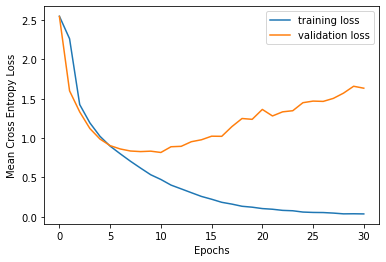

In [12]:
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Cross Entropy Loss')
#plt.ylim(0.0, 10)
plt.legend()

(0.0, 0.001)

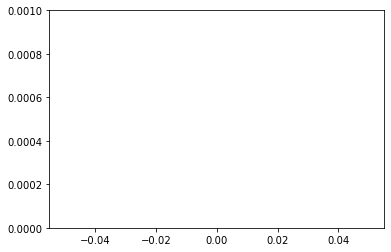

In [13]:
plt.plot(lr_history)
plt.ylim(0, 0.001)

0.7454


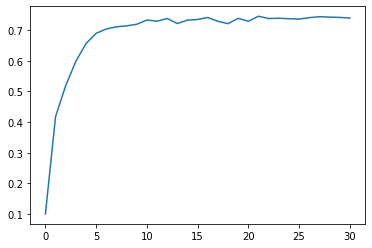

In [14]:
plt.plot(validation_accuracy)
print(max(validation_accuracy))

In [15]:
import csv
from google.colab import files

with open('train_loss', 'w') as f:
    write = csv.writer(f)
    write.writerow(training_loss)

with open('val_loss', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_loss)

with open('val_accuracy', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_accuracy)
    
with open('lr_history', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(lr_history)

files.download('train_loss')
files.download('val_loss')
files.download('val_accuracy')
files.download('lr_history')

ModuleNotFoundError: No module named 'google'